# Regressions

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from scipy.stats import skew
from sklearn import decomposition
import math
from sklearn.preprocessing import normalize

plt.style.use('ggplot')

On this step we use the train set to fit severl linear models.

In [2]:
# Load the train set
df = pd.read_csv('./data/new_train.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.head()

,Range,Date,Timestamp,Close,Body,TopWick,BottomWick,EURVolume,JPYClose,JPYRange,...,DownCount_14.0,DownCount_15.0,DownCount_16.0,DownCount_17.0,DownCount_18.0,DownCount_19.0,DownCount_20.0,DownCount_21.0,DownCount_0,MACD.Signal2_Sell
0,0.00021,2007-01-01,00:00:00,1.31926,0.00016,0.00000,0.00002,5.798790,119.013,0.002996,...,0,0,0,0,0,0,0,0,0,0
1,0.00025,2007-01-01,00:04:00,1.31928,0.00004,0.00008,0.00011,6.326149,119.003,0.016857,...,0,0,0,0,0,0,0,0,0,0
2,0.00021,2007-01-01,00:05:00,1.31943,0.00010,0.00000,0.00015,6.444767,119.013,0.012916,...,0,0,0,0,0,0,0,0,1,0
3,0.00022,2007-01-01,00:11:00,1.31928,0.00003,0.00012,0.00005,6.784457,119.012,0.009950,...,0,0,0,0,0,0,0,0,1,1
4,0.00020,2007-01-01,00:13:00,1.31935,0.00005,0.00005,0.00007,6.907055,119.017,0.006976,...,0,0,0,0,0,0,0,0,1,0


## Models fitted to the whole features set

First, we fit linear regression models to the whole dataset.

## Model 1: Linear regression on the whole set

In [3]:
data = df.copy()

# Create sets
X = data.copy().drop(['Range', 'Date', 'Timestamp'], axis=1)
y = data.copy()['Range']

X.shape

(239395, 82)

In [4]:
# Load numeric
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))
numerical

Index(['Close', 'Body', 'TopWick', 'BottomWick', 'EURVolume', 'JPYClose',
       'JPYRange', 'JPYVolume', 'CHFClose', 'CHFRange', 'CHFVolume',
       'XAUClose', 'XAURange', 'XAUVolume', 'forceindex', 'WillR5', 'WillR10',
       'WillR15', 'RSI5', 'RSI10', 'RSI15', 'ROC5', 'ROC10', 'MOM5', 'MOM10',
       'ATR5', 'ATR10', 'ADX.DIp', 'ADX.DIn', 'ADX.DX', 'ADX', 'SAR',
       'Stoch.fastK', 'Stoch.fastD', 'Stoch.slowD', 'BBands.dn', 'BBandsm.avg',
       'BBands.up', 'BBands.pctB', 'MACD', 'MACD.Signal'],
      dtype='object')

In [5]:

# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (167576, 82)
X_test : (71819, 82)
y_train : (167576,)
y_test : (71819,)


We create helper functions to evaluate results

In [6]:
def rmse_cv(model, X, y):
    '''
    A helper function to calculate the cross validated RMSE
    '''
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

In [7]:
def rmsle(model, X, y):
    '''
    Calculates rmsle as set by Kaggle
    '''
    return (math.sqrt(np.mean((np.log(np.exp(model.predict(X))) - np.log(np.exp(y))) ** 2)))

### Model 1a: Ridge regularization

Lowest rmse:  0.00014170010391235577
Optimal alpha:  [0.01005025]


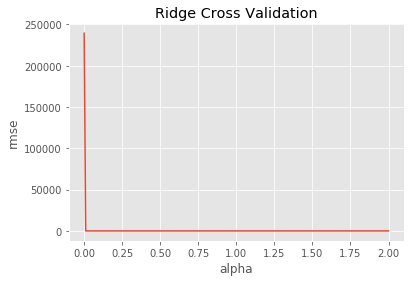

In [16]:
alphas = np.linspace(0.000,2,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.savefig('./output/ridge_whole.png', dpi=300)

print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.00014136194290983965
Model test accuracy (rmsle):  0.00014086901909314765


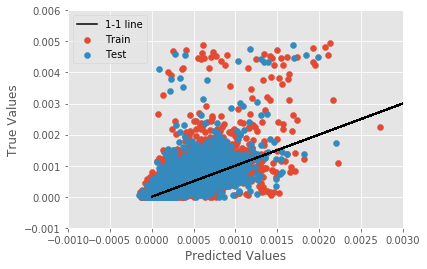

In [17]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

score1a = rmsle(model_tmp, X_test, y_test)

plt.scatter((model_tmp.predict(X_train)), (y_train), label='Train')
plt.scatter((model_tmp.predict(X_test)), (y_test), label='Test')
plt.plot((y),(y), c='black', label = '1-1 line')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
_ = plt.legend()
plt.xlim((-0.001, 0.003))
plt.ylim((-0.001, 0.006))
plt.savefig('./output/ridge_whole_true_vs_pred.png', dpi=300)


We train the model on the whole dataset

In [18]:
model1a = Ridge(alpha=alpha)
model1a.fit(X,y)



print('Model accuracy rmsle: ', rmsle(model1a, X, y))

Model accuracy rmsle:  0.0001402170199726632


We plot regression coefficients

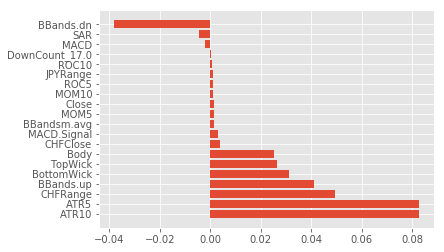

In [19]:
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/ridge_all_top20_coefs.png', dpi=300)

### Model 1b: LASSO regularization 

Alpha : 5e-05
Model accuracy train : 0.00017588887882225322
Model accuracy test: 0.00017406415602570554


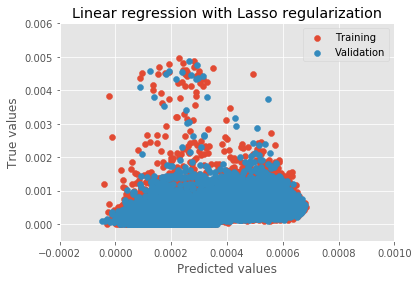

In [23]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy train :", rmsle(lasso, X_train, y_train))
print("Model accuracy test:", rmsle(lasso, X_test, y_test))
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

score1b =  rmsle(lasso, X_test, y_test)

# Plot predictions
plt.scatter((y_train_las), (y_train), label = "Training")
plt.scatter((y_test_las), (y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.xlim((-0.0002, 0.001))
plt.ylim((-0.0005, 0.006))
#plt.plot(np.exp(y), np.exp(y), c = "black")
plt.savefig('./output/lasso_all_true_vs_pred.png', dpi=300)


In [24]:
model1b = Lasso(alpha=alpha)
model1b.fit(X,y)


print('Model accuracy rmsle: ', rmsle(model1b, X, y))

Model accuracy rmsle:  0.00017525032002070013


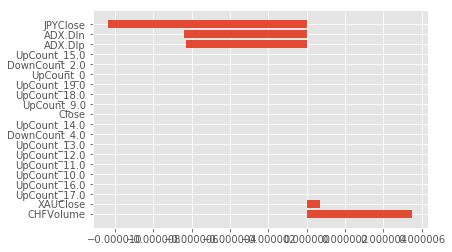

In [29]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)

plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/lasso_all_top20_coefs.png', dpi=300)


Train model on the whole dataset.

## Fitting the model on the selected features

The features that were selected in [Trees.ipynb](Trees.ipynb) are used to create regression models

In [44]:
feature_list_dt = list(['Body', 'TopWick', 'BottomWick','EURVolume','JPYVolume','JPYRange','CHFVolume','CHFRange','XAUVolume', 
                       'XAURange', 'ATR5', 'SAR', 'BBands.dn', 'BBandsm.avg', 'BBands.up'])
feature_list_dt

['Body',
 'TopWick',
 'BottomWick',
 'EURVolume',
 'JPYVolume',
 'JPYRange',
 'CHFVolume',
 'CHFRange',
 'XAUVolume',
 'XAURange',
 'ATR5',
 'SAR',
 'BBands.dn',
 'BBandsm.avg',
 'BBands.up']

In [45]:
# Load list of variables
select_var = feature_list_dt#pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))

# Set new X
X_sel = X[select_var].copy()

### Model 2a: Ridge regularization

In [46]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (167576, 15)
X_test : (71819, 15)
y_train : (167576,)
y_test : (71819,)


Lowest rmse:  0.00016066183003912352
Optimal alpha:  [0.01]


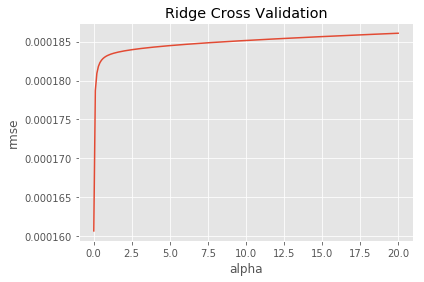

In [47]:

alphas = np.linspace(0.01,20,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.savefig('./output/ridge_selected.png', dpi=300)

print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.00015978665796425524
Model test accuracy (rmsle):  0.00015937056638055792


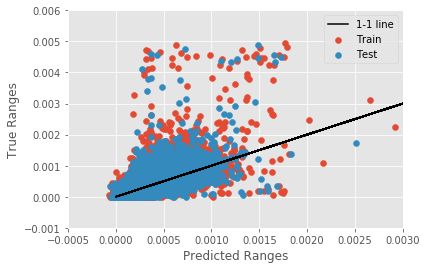

In [50]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test,y_test))

score2a = rmsle(model_tmp, X_test,y_test)

plt.scatter((model_tmp.predict(X_train)), (y_train), label='Train')
plt.scatter((model_tmp.predict(X_test)), (y_test), label='Test')
plt.plot((y),(y), c='black', label = '1-1 line')
plt.xlabel('Predicted Ranges')
plt.ylabel('True Ranges')
_ = plt.legend()
plt.xlim((-0.0005, 0.003))
plt.ylim((-0.001, 0.006))
plt.savefig('./output/ridge_selected_true_vs_pred.png', dpi=300)

We train the model on the whole dataset

In [51]:
model2a = Ridge(alpha=alpha)
model2a.fit(X_sel,y)



print('Model accuracy (rmsle): ', rmsle(model2a, X_sel, y))

Model accuracy (rmsle):  0.00015689027066651597


We plot regression coefficients

<BarContainer object of 15 artists>

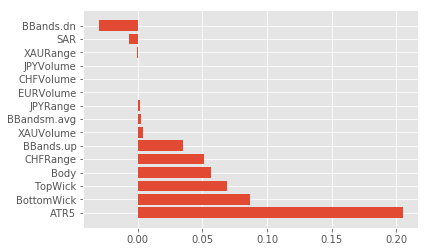

In [52]:
coefs = pd.DataFrame({'Feature':X_sel.columns.values, 'Coefficient':model2a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)

## Model 2b: LASSO regularization 

Alpha : 1.5
Model accuracy train : 0.00023514888204786733
Model accuracy test: 0.00023448683932646657


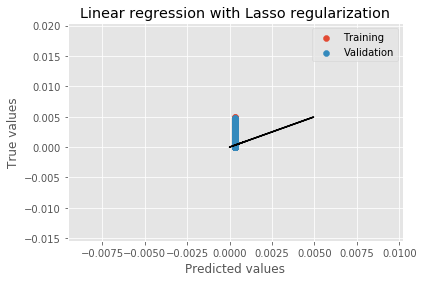

In [53]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy train :", rmsle(lasso, X_train, y_train))
print("Model accuracy test:", rmsle(lasso, X_test, y_test))
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

score2b =  rmsle(lasso, X_test, y_test)

# Plot predictions
plt.scatter((y_train_las), (y_train), label = "Training")
plt.scatter((y_test_las), (y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.plot((y), (y), c = "black")
plt.savefig('./output/lasso_selected_true_vs_pred.png', dpi=300)

In [54]:
model2b = Lasso(alpha=alpha)
model2b.fit(X_sel,y)



print('Model accuracy (rmsle): ', rmsle(model2b, X_sel, y))

Model accuracy (rmsle):  0.00023495046361035694


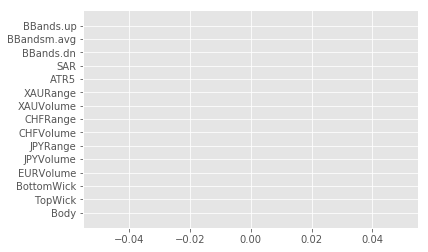

In [55]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X_sel.columns.values, 'Coefficient':model2b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/figX.png', dpi=300)
plt.show()


## Combine the models

We combine the models and pickle them for use on the train set

In [56]:
# Models

models = ['model1a', 'model1b', 'model2a', 'model2b']
scores = [score1a, score1b, score2a, score2b]

models_comb = pd.DataFrame({'model':models, 'score': scores})
print(models_comb)

# Pickle
pickle.dump(models_comb, open('./tmp/models_comb', 'wb'))

     model     score
0  model1a  0.000141
1  model1b  0.000174
2  model2a  0.000159
3  model2b  0.000234


Pickle models

In [57]:
models_obj = [model1a, model1b, model2a, model2b]

for i, model in enumerate(models_obj):
    name = './tmp/'+models[i]+'.model'
    pickle.dump(model, open(name, 'wb'))
